In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Functions

In [ ]:
def rbf_kernel(X, Y=None, gamma=0.5):
    if Y is None:
            Y = X
    K = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - Y[j])**2)
    return K

In [ ]:
def PreProcess(df, t, gamma=0.5):
    matrix_of_y = np.reshape(t, (-1, 1))
    matrix_of_x = np.vstack(df.values)
    kernel_matrix = rbf_kernel(matrix_of_x, gamma= gamma)
    signed_matrix = kernel_matrix * np.dot(matrix_of_y, matrix_of_y.T)
    return [signed_matrix, matrix_of_y, matrix_of_x, kernel_matrix]

In [ ]:
from cvxopt import matrix, solvers
import cvxopt
def Quadprog(signed_matrix, n, c, matrix_of_y):
  P = matrix([[float(value) for value in row] for row in signed_matrix])
  n = len(X_train)
  c = 20
  q = matrix([-1.0] * n)
  G = matrix(0.0, (2 * n, n))
  for i in range(n):
      G[i, i] = -1.0* c
      G[n + i, i] = c
  h = matrix([0.0] * n + [c] * n)
  A_eq = matrix([[float(value) for value in row] for row in matrix_of_y])
  b_eq = matrix([0.0])
  cvxopt.solvers.options['show_progress'] = False
  sol = solvers.qp(P, q, G, h, A_eq, b_eq)
  optimal_solution = sol['x']
  return optimal_solution


In [ ]:
def compute(optimal_solution, column, matrix_of_x, matrix_of_y, matrix_of_x_test, matrix_of_y_test, color, matrix_of_grid, Plot_df):
    gamma = 0.5
    kernel_matrix = rbf_kernel(matrix_of_x, gamma=gamma)
    # print(kernel_matrix.shape)
    kernel_matrix_test = rbf_kernel(matrix_of_x_test, matrix_of_x, gamma)
    kernel_matrix_grid = rbf_kernel(matrix_of_grid, matrix_of_x, gamma)
    x_values = np.array([])
    for i in range(len(optimal_solution)):
        x_values = np.append(x_values, optimal_solution[i])
    weight = 0
    for x_val, y_val, x_matrix in zip(x_values, matrix_of_y, kernel_matrix):
        element_wise_mult = np.multiply(np.dot(x_val, y_val), x_matrix)
        weight += element_wise_mult
    matrix_of_weight = np.array(weight)
    # print(matrix_of_weight.shape)
    min = float('inf')
    max = float('-inf')
    for i in range(len(kernel_matrix)):
      if (matrix_of_y[i] == 1):
        if (np.dot(matrix_of_weight,kernel_matrix[i]) < min):
          min = np.dot(matrix_of_weight, kernel_matrix[i])
      elif (matrix_of_y[i] == -1):
        if (np.dot(matrix_of_weight, kernel_matrix[i]) > max):
          max = np.dot(matrix_of_weight, kernel_matrix[i])
    b = -0.5*(min + max)
    check_grid = np.dot(kernel_matrix_grid, matrix_of_weight)
    check_grid = np.where(check_grid < 0, -1, 1)
    check_grid = np.where(check_grid == -1, 0, check_grid)
    check_train = np.dot(kernel_matrix, matrix_of_weight)
    check_train = check_train + b
    check_train = np.where(check_train < 0, -1, 1)
    check_test = np.dot(kernel_matrix_test, matrix_of_weight)
    check_test = check_test + b
    check_test = np.where(check_test < 0, -1, 1)
    matrix_of_y_test = matrix_of_y_test.reshape(-1)
    print("Test" ,(np.sum( check_test == matrix_of_y_test)/len(check_test))*100, "%")
    c = 0
    for i in range(len(check_train)):
        if (column[i] < 0 and check_train[i] < 0) or (column[i] > 0 and check_train[i] > 0):
            c += 1
    accuracy = (c / len(column)) * 100
    return [accuracy, check_train, check_test, check_grid]



#2-D datasets

In [ ]:
def plot_decision_boundaries(X_train, X_test, Plot_df, check_train, check_test, check_grid, i, plt):
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

    mask_train = (check_train == 1)
    mask_test = (check_test == 1)
    mask_grid = (check_grid == 1)
    plt.scatter(X_train[mask_train]["Feature1"], X_train[mask_train]["Feature2"], s=40, color=colors[i])
    plt.scatter(X_test[mask_test]["Feature1"], X_test[mask_test]["Feature2"], s=40, color=colors[i]  )
    plt.scatter(Plot_df[mask_grid]["Feature1"], Plot_df[mask_grid]["Feature2"], s=10, color=colors[i])


Test 100.0 %
Train 100.0 %
Test 100.0 %
Train 100.0 %
Test 99.36708860759494 %
Train 100.0 %
Test 99.36708860759494 %
Train 100.0 %
Test 100.0 %
Train 100.0 %
Test 100.0 %
Train 100.0 %


Test 100.0 %
Train 100.0 %


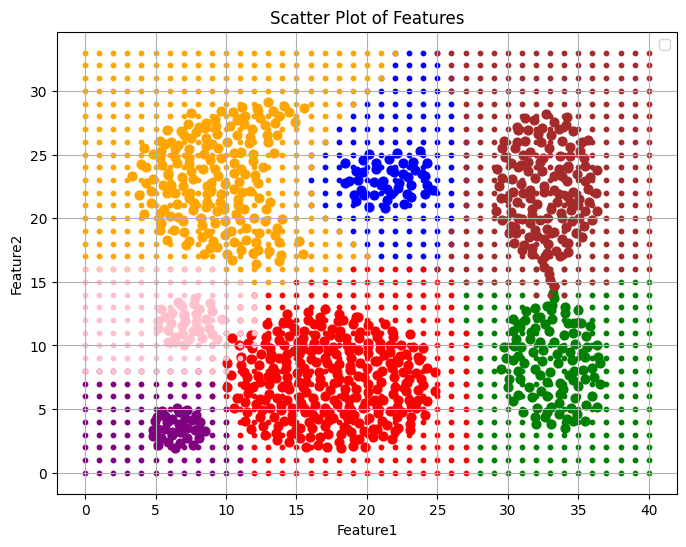

Test 98.75 %
Train 100.0 %
Test 100.0 %
Train 100.0 %
Test 98.75 %
Train 100.0 %
Test 98.75 %
Train 100.0 %
Test 100.0 %
Train 100.0 %


Test 100.0 %
Train 100.0 %


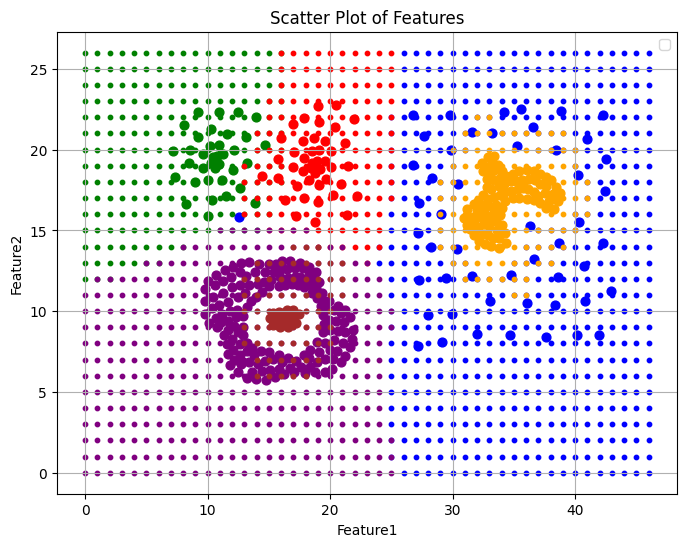

Test 100.0 %
Train 97.92 %


Test 100.0 %
Train 97.92 %


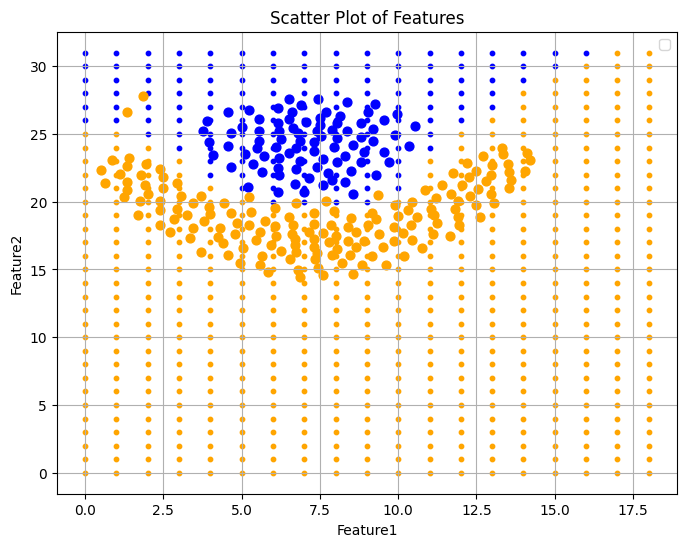

Test 100.0 %
Train 100.0 %


Test 100.0 %
Train 100.0 %


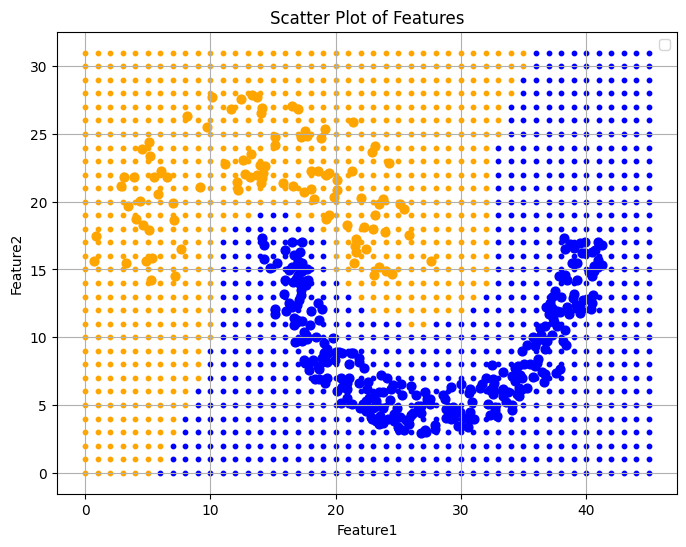

Test 98.33333333333333 %
Train 100.0 %
Test 100.0 %
Train 100.0 %


Test 95.0 %
Train 100.0 %


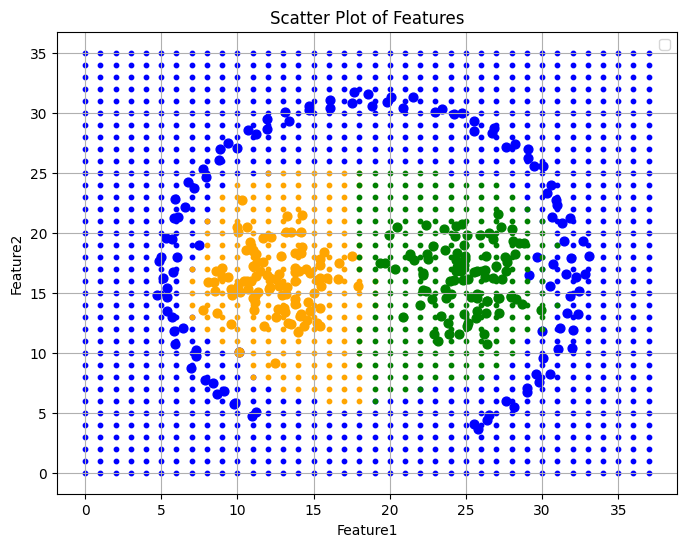

Test 100.0 %
Train 100.0 %
Test 100.0 %
Train 100.0 %


Test 100.0 %
Train 100.0 %


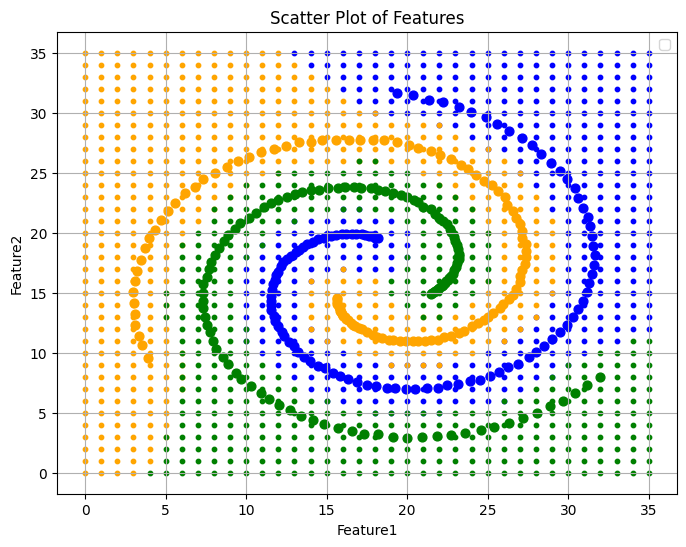

In [ ]:
csvs = ["/content/Aggregation.txt","/content/Compound.txt","/content/Flame.txt",
        "/content/Jain.txt", "/content/Pathbased.txt", "/content/Spiral.txt"]
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink']
for k in range(len(csvs)):
  column_names = ["Feature1", "Feature2", "Target"]
  df = pd.read_csv(csvs[k], skiprows=7, sep='\t', names=column_names)
  X = df[['Feature1', 'Feature2']]
  y = df['Target']
  max_X1 = df['Feature1'].max()
  max_X2 = df['Feature2'].max()
  Grid = []
  for x1 in range(int(max_X1)+5):
    for x2 in range(int(max_X2)+5):
        Grid.append({'Feature1': x1, 'Feature2': x2})
  Plot_df = pd.DataFrame(Grid)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  plt.figure(figsize=(8, 6))
  output = 0
  matrix_of_y = 0
  matrix_of_x = 0
  list_of_uni = df["Target"].unique()
  unique_classes = sorted(set(y))
  for i, target_class in enumerate(unique_classes):
      y_train_new = [1 if target == target_class else -1 for target in y_train]
      y_test_new = [1 if target == target_class else -1 for target in y_test]
      target = y_train
      output = PreProcess(copy.deepcopy(X_train), y_train_new)
      matrix_of_y = output[1]
      matrix_of_x = output[2]
      optimal_solution = Quadprog(output[3], len(df), 1, matrix_of_y)
      color = colors[i]
      computing = compute(np.array(optimal_solution), matrix_of_y, matrix_of_x, matrix_of_y, np.vstack(X_test.values), np.reshape(y_test_new, (-1, 1)), color, np.vstack(Plot_df.values), Plot_df)
      print("Train",round(computing[0],2) , "%")
      plot_decision_boundaries(X_train,X_test ,Plot_df, computing[1], computing[2], computing[3], i, plt)
      output = 0
      matrix_of_y = 0
      matrix_of_x = 0
  plt.xlabel('Feature1')
  plt.ylabel('Feature2')
  plt.title('Scatter Plot of Features')
  plt.legend()
  plt.grid(True)
  plt.show()